(60000, 784)


(-0.5, 27.5, 27.5, -0.5)

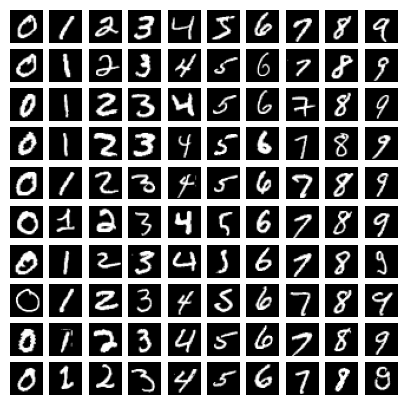

In [2]:
import os, sys
directory_path = os.path.dirname(os.path.abspath("__notebook__"))
sys.path.append('../../')
import numpy as np
import torch
np.random.seed(42)
import matplotlib.pyplot as plt
from models import crbm
from torchvision import datasets
from sklearn.preprocessing import StandardScaler

train_dataset = datasets.MNIST(root='./data', train=True, download=True)
scaler = StandardScaler()
X = train_dataset.data.numpy()
n_examples = X.shape[0]
X = X.reshape(n_examples, -1)
print(X.shape)
X = scaler.fit_transform(X)
y = train_dataset.targets
y_orig = y.numpy().copy()
y = torch.nn.functional.one_hot(y).numpy()
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
images = []
for i in range(10):
    images.append(X[y_orig == i][:10])
for j in range(len(images)):
    for k in range(10):
        image = images[k][j].reshape(1, -1)
        image = scaler.inverse_transform(image)
        image = np.clip(np.reshape(image, (28, 28)), 0, 255)
        axes[j][k].imshow(image, cmap='gray')
        axes[j][k].axis('off')
plt.axis('off')

In [3]:
model = crbm.ConditionalRBM(
    n_vis=784,
    n_cond=10,
    n_hid=300
)
stats = model.fit_adversarial(
    X=X[:10000],
    y=y[:10000],
    n_gibbs=10,
    lr=0.001,
    n_epochs=45,
    batch_size=100, 
    gamma=1,
    gamma_delay=45,
    rng_seed=0,
    verbose_interval=1,
    checkpoint_path=f'{directory_path}/crbm_checkpoints/crbm_mnist_demo.pth'
)

epoch: 00 of 45 | recon_mse: 0.515 | kl_data_model: 626.179 | kl_model_data: -237.326
epoch: 01 of 45 | recon_mse: 0.452 | kl_data_model: 547.397 | kl_model_data: -226.923
epoch: 02 of 45 | recon_mse: 0.431 | kl_data_model: 507.584 | kl_model_data: -225.689
epoch: 03 of 45 | recon_mse: 0.295 | kl_data_model: 529.618 | kl_model_data: -222.241
epoch: 04 of 45 | recon_mse: 0.408 | kl_data_model: 454.996 | kl_model_data: -188.799
epoch: 05 of 45 | recon_mse: 0.433 | kl_data_model: 514.455 | kl_model_data: -205.125
epoch: 06 of 45 | recon_mse: 0.464 | kl_data_model: 356.109 | kl_model_data: -174.945
epoch: 07 of 45 | recon_mse: 0.516 | kl_data_model: 320.068 | kl_model_data: -159.435
epoch: 08 of 45 | recon_mse: 0.558 | kl_data_model: 319.423 | kl_model_data: -171.202
epoch: 09 of 45 | recon_mse: 0.367 | kl_data_model: 284.248 | kl_model_data: -160.863
epoch: 10 of 45 | recon_mse: 0.294 | kl_data_model: 205.849 | kl_model_data: -140.089
epoch: 11 of 45 | recon_mse: 0.496 | kl_data_model: 27

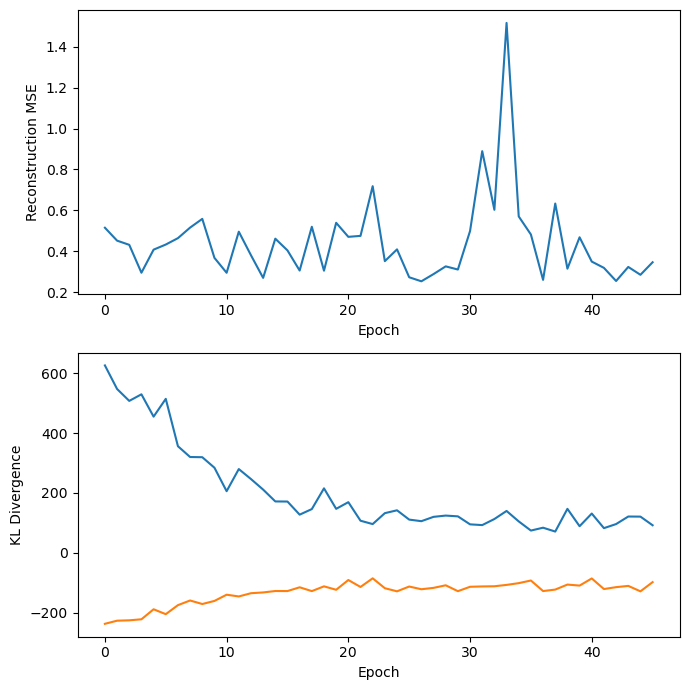

In [4]:
def visualize_learning(stats):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
    axs[0].plot(stats['epoch_num'], stats['recon_mse'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Reconstruction MSE')
    axs[1].plot(stats['epoch_num'], stats['kl_data_model'], label='Forward KL')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('KL Divergence')
    axs[1].plot(stats['epoch_num'], stats['kl_model_data'], label='Backward KL')
    plt.tight_layout()
visualize_learning(stats)

(-0.5, 27.5, 27.5, -0.5)

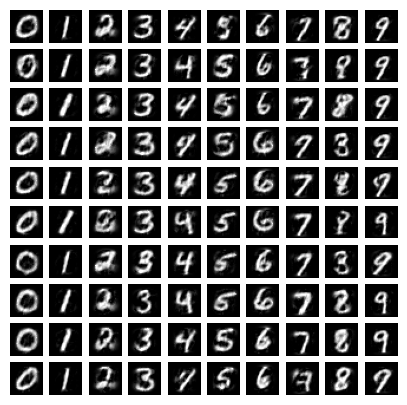

In [6]:
model = crbm.load(f'{directory_path}/crbm_checkpoints/crbm_mnist_demo.pth')
one_hots = np.diag(np.ones(10))
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
images = []
for i in range(10):
    model.reset_seed(i + 0)
    images.append(scaler.inverse_transform(
        model.reconstruct(v=np.zeros((10, 784)), c=one_hots, n_gibbs=100, add_noise=False)
    ))
for j in range(len(images)):
    for k in range(10):
        image = np.clip(np.reshape(images[j][k], (28, 28)), 0, 255)
        axes[j][k].imshow(image, cmap='gray')
        axes[j][k].axis('off')
plt.axis('off')